# Twitter Sentiment Analysis

In [2]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [6]:
dataset_path = os.path.join(r"D:\Projects Help\Danny\Twitter Sentiment Analysis WIth Streamlit\untrained_data.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: D:\Projects Help\Danny\Twitter Sentiment Analysis WIth Streamlit\untrained_data.csv


In [7]:
print("Dataset size:", len(df))

Dataset size: 50000


In [8]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [9]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [10]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 15.6 ms
Wall time: 41.1 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

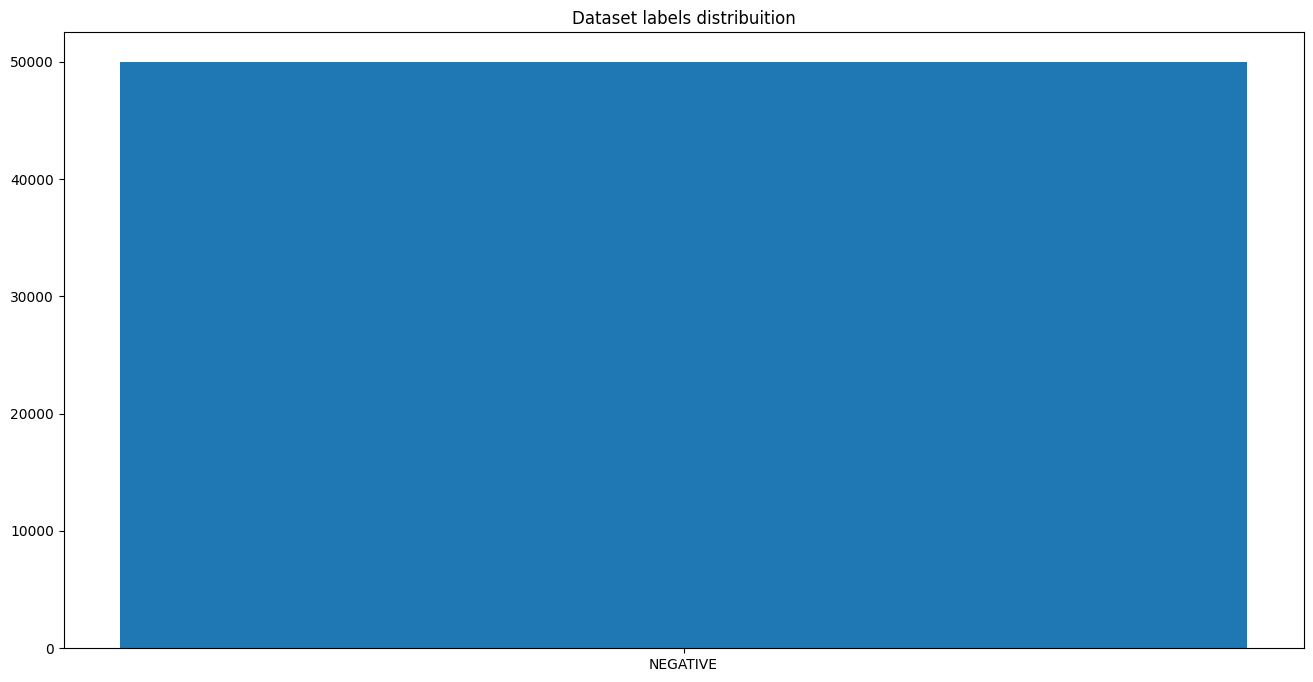

In [11]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 484 ms
Wall time: 1.9 s


### Split train and test

In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


### Word2Vec 

In [16]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 31.2 ms
Wall time: 76.5 ms


In [17]:
from gensim.models import Word2Vec

# Set your desired values for vector_size, window, and min_count
vector_size = 100  # Example size value, adjust according to your needs
window = 5         # Example window value, adjust according to your needs
min_count = 1      # Example min_count value, adjust according to your needs

# Initialize Word2Vec model with the updated parameter names
w2v_model = Word2Vec(vector_size=vector_size, 
                     window=window, 
                     min_count=min_count, 
                     workers=8)

2023-11-19 21:36:16,892 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2023-11-19T21:36:16.892845', 'gensim': '4.3.2', 'python': '3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}


In [18]:
w2v_model.build_vocab(documents)

2023-11-19 21:36:18,088 : INFO : collecting all words and their counts
2023-11-19 21:36:18,088 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-11-19 21:36:18,137 : INFO : PROGRESS: at sentence #10000, processed 72776 words, keeping 13045 word types
2023-11-19 21:36:18,185 : INFO : PROGRESS: at sentence #20000, processed 146393 words, keeping 19910 word types
2023-11-19 21:36:18,270 : INFO : PROGRESS: at sentence #30000, processed 218766 words, keeping 25263 word types
2023-11-19 21:36:18,357 : INFO : collected 30006 word types from a corpus of 291092 raw words and 40000 sentences
2023-11-19 21:36:18,359 : INFO : Creating a fresh vocabulary
2023-11-19 21:36:18,489 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 30006 unique words (100.00% of original 30006, drops 0)', 'datetime': '2023-11-19T21:36:18.489894', 'gensim': '4.3.2', 'python': '3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]', 'platform'

In [19]:
words = list(w2v_model.wv.index_to_key)  # Convert the index_to_key iterator to a list
vocab_size = len(words)
print("Vocab size:", vocab_size)
print("Words:", words)

Vocab size: 30006
Words: ['work', 'go', 'get', 'day', 'back', 'today', 'like', 'going', 'got', 'still', 'good', 'want', 'really', 'time', 'im', 'one', 'quot', 'sad', 'last', 'sleep', 'home', 'night', 'know', 'miss', '2', 'oh', 'tomorrow', 'need', 'school', 'wish', 'much', 'think', 'morning', 'lol', 'well', 'bad', 'sorry', 'feel', 'u', 'see', 'amp', 'hate', 'bed', 'sick', 'though', 'love', 'twitter', 'getting', 'would', 'hope', 'new', 'right', '3', 'could', 'tired', 'even', 'week', 'tonight', 'feeling', 'cant', 'dont', 'make', 'way', 'gonna', 'working', 'come', 'wanna', 'days', 'never', 'fun', 'people', '4', 'better', 'lost', 'weekend', 'early', 'yet', 'already', 'hours', 'another', 'great', 'cold', 'damn', 'find', 'yeah', 'trying', 'long', 'watching', 'missed', 'sucks', 'haha', 'next', 'ugh', 'away', 'soon', '1', 'man', 'bored', 'nice', 'phone', 'poor', 'went', 'missing', 'done', 'someone', 'left', 'thing', 'little', '5', 'something', 'rain', 'take', 'house', 'looking', 'ready', 'first

In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-11-19 21:36:22,556 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30006 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2023-11-19T21:36:22.556660', 'gensim': '4.3.2', 'python': '3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
2023-11-19 21:36:23,096 : INFO : EPOCH 0: training on 291092 raw words (272236 effective words) took 0.5s, 537032 effective words/s
2023-11-19 21:36:23,531 : INFO : EPOCH 1: training on 291092 raw words (272443 effective words) took 0.4s, 638299 effective words/s
2023-11-19 21:36:23,952 : INFO : EPOCH 2: training on 291092 raw words (272124 effective words) took 0.4s, 693466 effective words/s
2023-11-19 21:36:24,272 : INFO : EPOCH 3: training on 291092 raw words (272564 effective words) took 0.3s, 916775 effective words/s
2023-11-19 21:36:24,567 : INFO : EPOCH 4: training o

CPU times: total: 24.2 s
Wall time: 10.7 s


(8716509, 9314944)

In [21]:
similar_words = w2v_model.wv.most_similar("love")
print("Words similar to 'love':", similar_words)

Words similar to 'love': [('spain', 0.46531379222869873), ('tantrum', 0.4574670195579529), ('huggers', 0.435000479221344), ('mw2', 0.4349137544631958), ('rollerblade', 0.42866402864456177), ('baudrillard', 0.4239594340324402), ('shorter', 0.42367881536483765), ('lt', 0.42303788661956787), ('snipers', 0.4229414165019989), ('overheat', 0.42269018292427063)]


### Tokenize Text

In [22]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 30007
CPU times: total: 312 ms
Wall time: 1.04 s


In [23]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 188 ms
Wall time: 852 ms


### Label Encoder 

In [24]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'NEUTRAL']

In [25]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [26]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [27]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### Embedding layer

In [29]:
# Assuming W2V_SIZE is set to the desired dimensionality of your Word2Vec embeddings (e.g., 100)
W2V_SIZE = 100

# Initialize your embedding_matrix with zeros
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, W2V_SIZE))

# Populate the embedding_matrix with word vectors
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        # Assign the Word2Vec embeddings directly
        embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

(30007, 100)


In [30]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          3000700   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 3081201 (11.75 MB)
Trainable params: 80501 (314.46 KB)
Non-trainable params: 3000700 (11.45 MB)
_________________________________________________________________


### Compile model

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [34]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
36/36 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9776 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-19 21:49:33,724 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 698s 19s/step - loss: 0.1204 - accuracy: 0.9776 - val_loss: 2.7034e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/8
36/36 [==============================] - ETA: 0s - loss: 3.5639e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-19 22:05:56,577 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 983s 27s/step - loss: 3.5639e-05 - accuracy: 1.0000 - val_loss: 1.6092e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/8
36/36 [==============================] - ETA: 0s - loss: 2.7192e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-19 22:28:45,650 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 1369s 38s/step - loss: 2.7192e-05 - accuracy: 1.0000 - val_loss: 1.4001e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/8
36/36 [==============================] - ETA: 0s - loss: 2.4146e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-19 22:52:40,319 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 1435s 40s/step - loss: 2.4146e-05 - accuracy: 1.0000 - val_loss: 1.2240e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/8
36/36 [==============================] - ETA: 0s - loss: 2.1191e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-19 23:17:23,207 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 1483s 41s/step - loss: 2.1191e-05 - accuracy: 1.0000 - val_loss: 1.0693e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/8
36/36 [==============================] - ETA: 0s - loss: 1.8669e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-19 23:42:04,334 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 1481s 41s/step - loss: 1.8669e-05 - accuracy: 1.0000 - val_loss: 9.3710e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/8
36/36 [==============================] - ETA: 0s - loss: 1.7371e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-20 00:07:27,789 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 1523s 42s/step - loss: 1.7371e-05 - accuracy: 1.0000 - val_loss: 9.2481e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 8/8
36/36 [==============================] - ETA: 0s - loss: 1.7113e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-11-20 00:32:34,609 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


36/36 [==============================] - 1507s 42s/step - loss: 1.7113e-05 - accuracy: 1.0000 - val_loss: 9.1196e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
CPU times: total: 49min 3s
Wall time: 2h 54min 39s


### Evaluate

In [35]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 28s 3s/step - loss: 9.0034e-06 - accuracy: 1.0000

ACCURACY: 1.0
LOSS: 9.00340819498524e-06
CPU times: total: 14.3 s
Wall time: 27.7 s


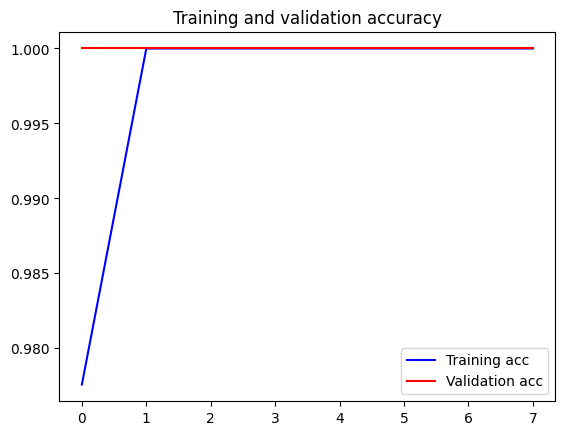

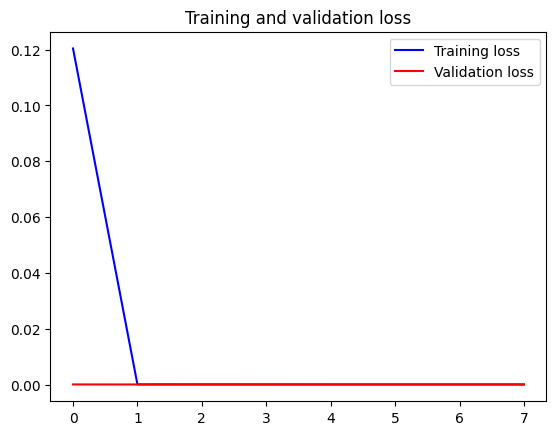

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### Predict

In [39]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [40]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [41]:
predict("I love the music")

1/1 [==============================] - 0s 494ms/step


C:\Users\seera\AppData\Local\Temp\ipykernel_10912\1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEGATIVE',
 'score': 1.074339343176689e-05,
 'elapsed_time': 0.574528694152832}

In [42]:
predict("I hate the rain")

1/1 [==============================] - 0s 84ms/step


C:\Users\seera\AppData\Local\Temp\ipykernel_10912\1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEGATIVE',
 'score': 1.0567800018179696e-05,
 'elapsed_time': 0.14548921585083008}

In [43]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 97ms/step


C:\Users\seera\AppData\Local\Temp\ipykernel_10912\1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEGATIVE',
 'score': 8.044756214076187e-06,
 'elapsed_time': 0.17725372314453125}

### Confusion Matrix

In [44]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 18s 9s/step
CPU times: total: 25.7 s
Wall time: 18.5 s


In [45]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

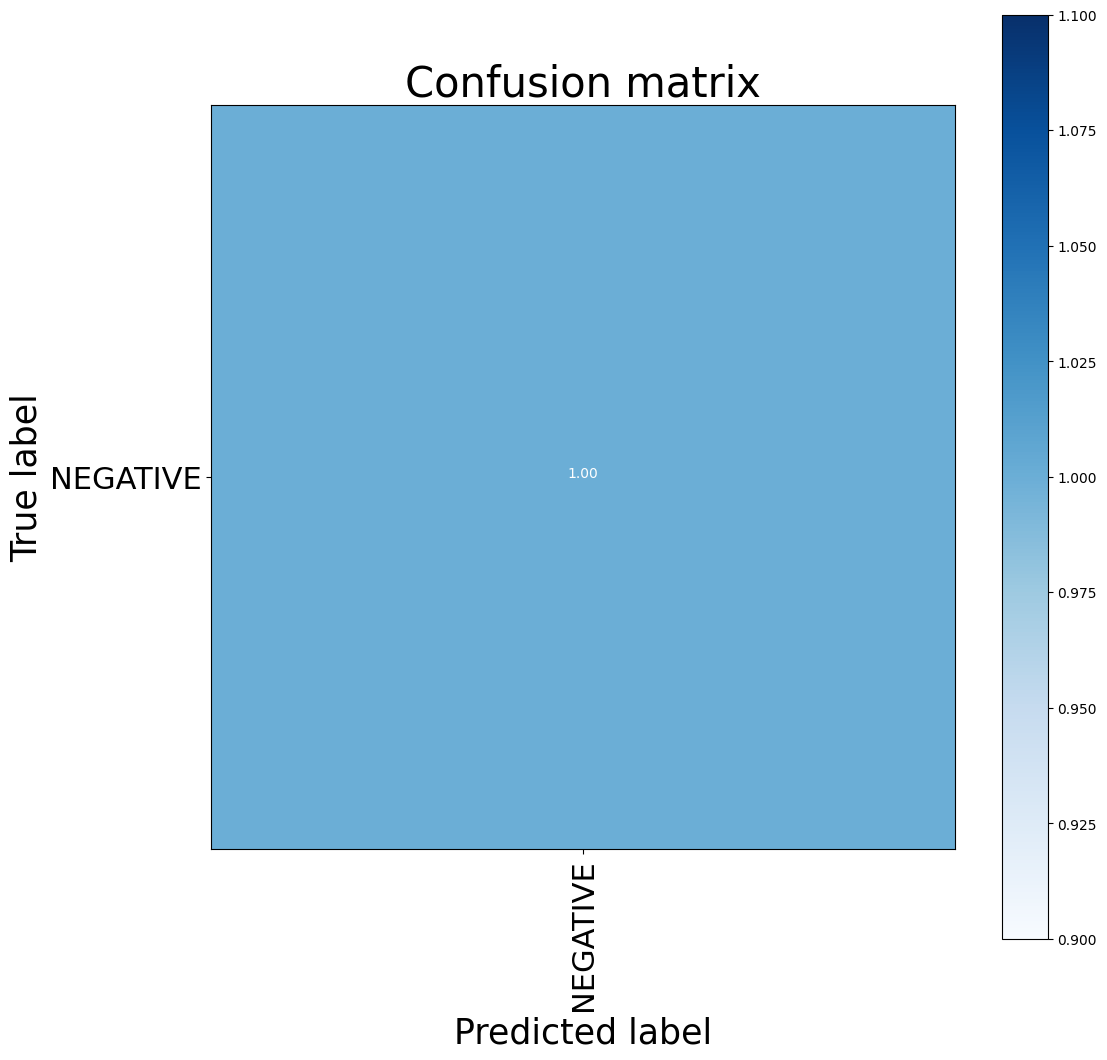

CPU times: total: 281 ms
Wall time: 837 ms


In [46]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [47]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00     10000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Accuracy Score

In [48]:
accuracy_score(y_test_1d, y_pred_1d)

1.0

### Save model

In [49]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

c:\Users\seera\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-11-20 00:50:07,288 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-11-20T00:50:07.288766', 'gensim': '4.3.2', 'python': '3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'saving'}
2023-11-20 00:50:07,291 : INFO : not storing attribute cum_table
2023-11-20 00:50:07,352 : INFO : saved model.w2v
